# YOLO (You Only Look Once) Implementation for Traffic Assesment

## Prerequisites

#### Installing python dependencies

In [1]:
!pip install -r requirements.txt

#### Importing required libraries

In [1]:
import os
import random

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Concatenate, concatenate, Dropout, LeakyReLU, Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image
import matplotlib.patches as patches
import configparser
import ast
from xml.dom import minidom

from tensorflow.python.client import device_lib
print('Tensorflow version: {}'.format(tf.__version__))
print('GPU: {}'.format([x.name for x in device_lib.list_local_devices()]))

Tensorflow version: 2.0.0
GPU: ['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0']


#### Setting YOLO Parameters

In [3]:
with open('./config/classes.names') as class_file:
    LABELS = class_file.read().splitlines()


In [7]:
config = configparser.ConfigParser()
config.read('config/params.config')

IMAGE_W             = int(config['YOLO']['IMAGE_W'])
IMAGE_H             = int(config['YOLO']['IMAGE_H'])
GRID_W              = int(config['YOLO']['GRID_W'])
GRID_H              = int(config['YOLO']['GRID_H'])
BOXES               = int(config['YOLO']['BOXES'])
CLASSES             = int(config['YOLO']['CLASSES'])
MIN_SCORE           = float(config['YOLO']['MIN_SCORE'])
MIN_IOU             = float(config['YOLO']['MIN_IOU'])
ANCHORS             = ast.literal_eval(config['YOLO']['ANCHORS'])

TRAIN_BATCH_SIZE    = int(config['TRAINING']['TRAIN_BATCH_SIZE'])
VAL_BATCH_SIZE      = int(config['TRAINING']['VAL_BATCH_SIZE'])
EPOCHS              = int(config['TRAINING']['EPOCHS'])

IMAGE_FOLDER        = config['DIR']['IMAGES']
ANNOTATION_FOLDER   = config['DIR']['ANNOTATIONS']

## Loading training/validation datasets

#### Defining a class for the annotated image data

In [5]:
class AnnotatedImage:
    class Object:
        def __init__(self, classs, bbox):
            self.classs = classs
            self.bbox = bbox

        def bbox_corner(self, side):
            if side == min:
                return (
                    self.bbox['x'] - self.bbox['w'] / 2,
                    self.bbox['y'] - self.bbox['h'] / 2)

            if side == max:
                return (
                    self.bbox['x'] + self.bbox['w'] / 2,
                    self.bbox['y'] + self.bbox['h'] / 2)

        def to_printable(self):
            return (self.classs, [bbox for bbox in self.bbox.values()])

    def __init__(self, name):
        self.name = name
        self.filepath = './data/VOCdevkit/VOC2012/JPEGImages/' + name + '.jpg'
        self.image = np.array(Image.open(self.filepath).resize(
            (RES, RES), Image.ANTIALIAS), dtype=np.uint8)
        self.objects = self.__parse_objects()

    def __parse_objects(self):
        def __parse_object_coords(self, xmin, ymin, xmax, ymax):
            return {'x': (xmax + xmin)/2, 'y': (ymax + ymin)/2, 'w': xmax - xmin, 'h': ymax - ymin}

        document = minidom.parse(
            './data/VOCdevkit/VOC2012/Annotations/' + self.name + '.xml')
        xml_objects = document.getElementsByTagName('object')
        parsed_objects = []

        for xml_object in xml_objects:
            try:
                classs = list(labels.values()).index(
                    xml_object.getElementsByTagName('name')[0].firstChild.nodeValue) + 1
            except:
                continue

            xml_bbox = xml_object.getElementsByTagName('bndbox')[0]
            width = int(document.getElementsByTagName('size')[
                        0].getElementsByTagName('width')[0].firstChild.nodeValue)
            height = int(document.getElementsByTagName('size')[
                         0].getElementsByTagName('height')[0].firstChild.nodeValue)

            parsed_objects.append(self.Object(
                classs=classs,
                bbox=__parse_object_coords(
                    self,
                    xmin=int(int(xml_bbox.getElementsByTagName('xmin')
                                 [0].firstChild.nodeValue)*(RES/width)),
                    ymin=int(int(xml_bbox.getElementsByTagName('ymin')
                                 [0].firstChild.nodeValue)*(RES/height)),
                    xmax=int(int(xml_bbox.getElementsByTagName('xmax')
                                 [0].firstChild.nodeValue)*(RES/width)),
                    ymax=int(int(xml_bbox.getElementsByTagName('ymax')[0].firstChild.nodeValue)*(RES/height)))
            ))

        return parsed_objects

    def to_printable(self):
        return (self.filepath, [object.to_printable() for object in self.objects])

#### Getting a list of all the train/val images of cars

In [6]:
# Loading all the filepaths in a list
train_images_filepaths = []
val_images_filepaths = []

for label in range(1, len(labels) + 1):
    train_file = open('./data/VOCdevkit/VOC2012/ImageSets/Main/' + labels[label] + "_train.txt", 'r')
    val_file = open('./data/VOCdevkit/VOC2012/ImageSets/Main/' + labels[label] + "_val.txt", 'r')
    for line in train_file:
        train_images_filepaths.append(line[:-4])
    for line in val_file:
        val_images_filepaths.append(line[:-4])
    
# Removing duplicate filepaths
train_images_filepaths = list(dict.fromkeys(train_images_filepaths))
val_images_filepaths = list(dict.fromkeys(val_images_filepaths))

'Number of images to be loaded: train - {}, val - {}'.format(len(train_images_filepaths), len(val_images_filepaths))

'Number of images to be loaded: train - 5717, val - 5823'

#### Loading the train/val images into separate array

In [7]:
train_images = []
val_images = []

for filename in train_images_filepaths[0:100]:
    train_images.append(AnnotatedImage(filename))

for filename in val_images_filepaths[0:80]:
    val_images.append(AnnotatedImage(filename))

#### Removing labels which are not going to be used

In [8]:
# for image in train_images:
#     for object in image.objects:
#         if object.name not in labels.values():
#             image.objects.remove(object)
    
# for image in val_images:
#     for object in image.objects:
#         if object.name not in labels.values():
#             image.objects.remove(object)

#### Resizing the images for a consistent model input shape

In [9]:
# for image in train_images:
#     image.image = np.array(image.image.resize((RES, RES), Image.ANTIALIAS), dtype=np.uint8)

# for image in val_images:
#     image.image = np.array(image.image.resize((RES, RES), Image.ANTIALIAS), dtype=np.uint8)

#### Testing whether the images & objects are loaded properly

('./data/VOCdevkit/VOC2012/JPEGImages/2008_000176.jpg', [(3, [226.0, 272.0, 444, 282]), (6, [224.5, 283.5, 91, 265])])


<Figure size 432x288 with 0 Axes>

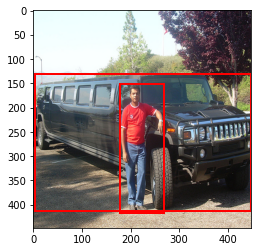

('./data/VOCdevkit/VOC2012/JPEGImages/2008_000405.jpg', [])


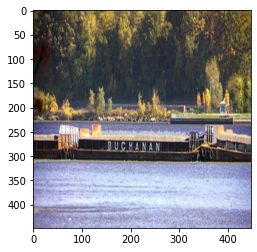

('./data/VOCdevkit/VOC2012/JPEGImages/2008_000399.jpg', [(3, [225.5, 241.0, 395, 192])])


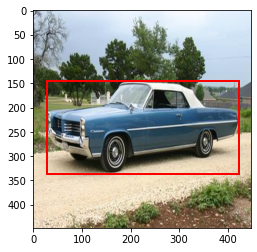

('./data/VOCdevkit/VOC2012/JPEGImages/2008_000148.jpg', [])


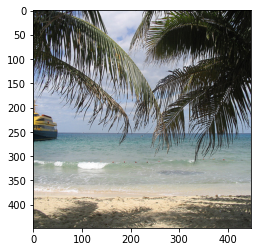

('./data/VOCdevkit/VOC2012/JPEGImages/2008_000132.jpg', [(6, [405.0, 214.0, 38, 176]), (6, [53.0, 222.5, 38, 181]), (2, [224.0, 376.0, 448, 144])])


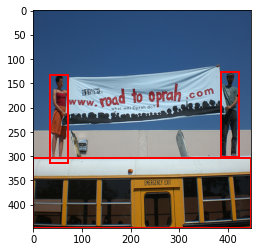

In [10]:
plt.figure()
for i in range(0, 5):
    rng = random.randint(1, len(train_images))
    fig, ax = plt.subplots(1)
    ax.imshow(train_images[rng].image)
    
    for object in train_images[rng].objects:
        rect = patches.Rectangle(
            (object.bbox_corner(min)),
            object.bbox_corner(max)[0] - object.bbox_corner(min)[0],
            object.bbox_corner(max)[1] - object.bbox_corner(min)[1],
            linewidth=2,
            edgecolor='#ff0000',
            facecolor='none'
        )
        ax.add_patch(rect)
        
    print(train_images[rng].to_printable())
    plt.show()

#### Formating image lables

In [11]:
def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

In [12]:
train_labels = []
for i in train_images:
    label = [[[[[0 for i in range(5)] for i in range(B)], [0 for i in range(C)] ] for col in range(S)] for row in range(S)]
    for dim1 in range(S):
        for dim2 in range(S):
            ss = int(RES / S)
            for object in i.objects:                
#                 print((dim1 * ss in range(int(object.bbox_corner(min)[0]), int(object.bbox_corner(max)[0]))) or ((dim1 + 1) * ss in range(int(object.bbox_corner(min)[0]), int(object.bbox_corner(max)[0]))))
                if (((dim1 * ss in range(int(object.bbox_corner(min)[0]), int(object.bbox_corner(max)[0]))) and (dim2 * ss in range(int(object.bbox_corner(min)[1]), int(object.bbox_corner(max)[1])))) or ((dim1 + 1) * ss in range(int(object.bbox_corner(min)[0]), int(object.bbox_corner(max)[0])) and ((dim2 + 1) * ss in range(int(object.bbox_corner(min)[1]), int(object.bbox_corner(max)[1]))))):
                    label[dim1][dim2][1][object.classs - 1] = 1
            
                if int(object.bbox['x']) in range(dim1 * ss, (dim1 + 1) * ss) and int(object.bbox['y']) in range(dim2 * ss, (dim2 + 1) * ss):
                    for b, bbox_prediction in enumerate(label[dim1][dim2][0]):
                        if bbox_prediction[-1] == 0:
                            label[dim1][dim2][0][b] = [(object.bbox['x'] - dim1 * ss) / ss, (object.bbox['y'] - dim2 * ss) / ss, object.bbox['w'] / RES, object.bbox['h'] / RES, object.classs]
                            break
                            
            label[dim1][dim2] = flatten(label[dim1][dim2])
    train_labels.append(label)
    
train_labels = np.array(train_labels)

In [13]:
val_labels = []
for i in val_images:
    label = [[[[[0 for i in range(5)] for i in range(B)], [0 for i in range(C)] ] for col in range(S)] for row in range(S)]
    for dim1 in range(S):
        for dim2 in range(S):
            ss = int(RES / S)
            for object in i.objects:
                if (((dim1 * ss in range(int(object.bbox_corner(min)[0]), int(object.bbox_corner(max)[0]))) and (dim2 * ss in range(int(object.bbox_corner(min)[1]), int(object.bbox_corner(max)[1])))) or ((dim1 + 1) * ss in range(int(object.bbox_corner(min)[0]), int(object.bbox_corner(max)[0])) and ((dim2 + 1) * ss in range(int(object.bbox_corner(min)[1]), int(object.bbox_corner(max)[1]))))):
                    label[dim1][dim2][1][object.classs - 1] = 1

                if int(object.bbox['x']) in range(dim1 * ss, (dim1 + 1) * ss) and int(object.bbox['y']) in range(dim2 * ss, (dim2 + 1) * ss):
                    for b, bbox_prediction in enumerate(label[dim1][dim2][0]):
                        if bbox_prediction[-1] == 0:
                            label[dim1][dim2][0][b] = [(object.bbox['x'] - dim1 * ss) / ss, (object.bbox['y'] - dim2 * ss) / ss, object.bbox['w'] / RES, object.bbox['h'] / RES, object.classs]
                            break

            label[dim1][dim2] = flatten(label[dim1][dim2])
    val_labels.append(label)
    
val_labels = np.array(val_labels)

In [14]:
train_images = np.array([i.image for i in train_images], dtype='float32') / 255

In [15]:
val_images = np.array([i.image for i in val_images], dtype='float32') / 255

## Defining and training the neural network

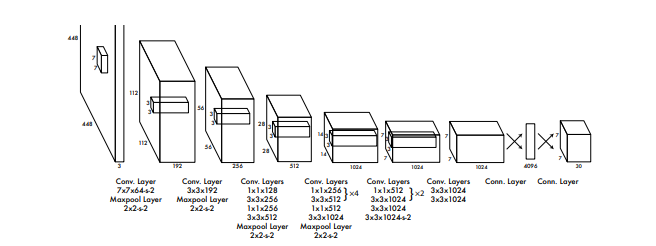

In [16]:
class SpaceToDepth(tf.keras.layers.Layer):

    def __init__(self, block_size, **kwargs):
        self.block_size = block_size
        super(SpaceToDepth, self).__init__(**kwargs)

    def call(self, inputs):
        x = inputs
        batch, height, width, depth = K.int_shape(x)
        batch = -1
        reduced_height = height // self.block_size
        reduced_width = width // self.block_size
        y = K.reshape(x, (batch, reduced_height, self.block_size,
                             reduced_width, self.block_size, depth))
        z = K.permute_dimensions(y, (0, 1, 3, 2, 4, 5))
        t = K.reshape(z, (batch, reduced_height, reduced_width, depth * self.block_size **2))
        return t

    def compute_output_shape(self, input_shape):
        shape =  (input_shape[0], input_shape[1] // self.block_size, input_shape[2] // self.block_size,
                  input_shape[3] * self.block_size **2)
        return tf.TensorShape(shape)

In [17]:
input_image = tf.keras.layers.Input((RES, RES, 3), dtype='float32')

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)

skip_connection = SpaceToDepth(block_size=2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x) # add dropout

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 23
output = Conv2D(17, (1,1), strides=(1,1), padding='same', name='conv_23')(x)

model = tf.keras.models.Model(input_image, output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 448, 448, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 448, 448, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 448, 448, 32) 0           norm_1[0][0]                     
______________________________________________________________________________________________

In [18]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
checkpoint_path = "train_checkpont/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

p_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [20]:
print(train_images.shape)
print(train_labels.shape)
print(val_images.shape)
print(val_labels.shape)

(100, 448, 448, 3)
(100, 7, 7, 17)
(80, 448, 448, 3)
(80, 7, 7, 17)


In [21]:
train_labels[0]

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0. 

In [22]:
detector = model.fit(
    train_images, train_labels, epochs=10, 
    validation_data=(
        val_images,
        val_labels)
)

Train on 100 samples, validate on 80 samples
Epoch 1/10
 32/100 [========>.....................] - ETA: 1s

ValueError: Can not squeeze dim[3], expected a dimension of 1, got 17 for 'metrics/accuracy/Squeeze' (op: 'Squeeze') with input shapes: [?,7,7,17].